 <h1 align="center"> Online Payment Fraud Detection:</h1>

<h2 align="center"> A Data-Driven Machine Learning Project </h2>

### Introduction:
This project is a machine learning classification model to detect fraudulent transactions in online payments. The dataset used is highly imbalanced, with far more non-fraudulent transactions than fraudulent ones. The project explores multiple algorithms and techniques to address the imbalance and improve the detection of fraud.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,auc

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')  # To suppress warnings


## Data Loading and Analyzing:

In [2]:
df = pd.read_csv('data1.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0


In [3]:
print("Rows and Columns")
print(df.shape)
df.head(5)

Rows and Columns
(208213, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0


##### Columns




In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208213 entries, 0 to 208212
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            208213 non-null  int64  
 1   type            208213 non-null  object 
 2   amount          208213 non-null  float64
 3   nameOrig        208213 non-null  object 
 4   oldbalanceOrg   208213 non-null  float64
 5   newbalanceOrig  208213 non-null  float64
 6   nameDest        208213 non-null  object 
 7   oldbalanceDest  208213 non-null  float64
 8   newbalanceDest  208213 non-null  float64
 9   isFraud         208213 non-null  int64  
 10  isFlaggedFraud  208213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 17.5+ MB


In [5]:
df.rename(columns={'type':'transaction_type'},inplace=True)

In [6]:
cols_to_transform = ['amount','oldbalanceOrg','newbalanceOrig']
df[cols_to_transform] = df[cols_to_transform].astype('int')
df.dtypes

step                  int64
transaction_type     object
amount                int32
nameOrig             object
oldbalanceOrg         int32
newbalanceOrig        int32
nameDest             object
oldbalanceDest      float64
newbalanceDest      float64
isFraud               int64
isFlaggedFraud        int64
dtype: object

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00
mean,24.21,231259.33,912345.22,872604.07,925948.79,1195510.94,0.04,0.00
std,81.95,627002.48,2804990.99,2778976.28,2419683.44,2715619.94,0.19,0.01
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,12609.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,10.00,76276.00,20894.00,0.00,40958.30,128019.46,0.00,0.00
75%,12.00,242276.00,227866.00,204284.00,738531.50,1186317.31,0.00,0.00
max,743.00,10000000.00,59585040.00,49585040.00,236230516.82,236726494.66,1.00,1.00


#### Class imbalance 

In [8]:
df['isFraud'].value_counts()

# We have class imbalance in the Fraudulent(1) transactions.

isFraud
0    200000
1      8213
Name: count, dtype: int64

In [9]:
cat_column = ['transaction_type','isFraud','isFlaggedFraud']

for col in cat_column:
    print(f"column => {col} = {df[col].unique()}")

column => transaction_type = ['TRANSFER' 'CASH_OUT' 'PAYMENT' 'DEBIT' 'CASH_IN']
column => isFraud = [1 0]
column => isFlaggedFraud = [0 1]


#### Features:

## Data Cleaning

In [10]:
print("Checking for NA Values")

print(df.isna().sum())

Checking for NA Values
step                0
transaction_type    0
amount              0
nameOrig            0
oldbalanceOrg       0
newbalanceOrig      0
nameDest            0
oldbalanceDest      0
newbalanceDest      0
isFraud             0
isFlaggedFraud      0
dtype: int64


In [11]:
print("Checking for Duplicates")

print(df.duplicated().sum())

Checking for Duplicates
0


#### Box plots to visualize outliers

In [12]:
df.columns

Index(['step', 'transaction_type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [13]:
numeric_columns = df.select_dtypes(['int64','float64']).columns
numeric_columns

Index(['step', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

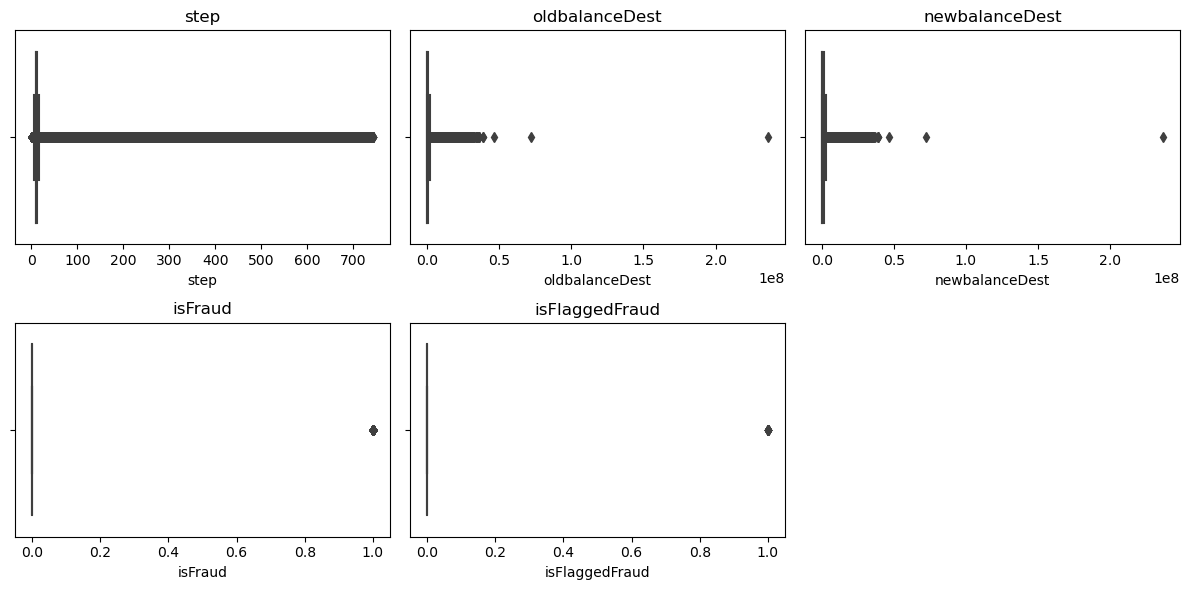

In [14]:
# Create a 2-row, 3-column subplot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # 2 rows, 3 columns

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through the first 6 numeric columns and plot
for i, col in enumerate(numeric_columns[:6]):  # Only the first 6 columns
    sns.boxplot(data=df, x=df[col], ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots if fewer than 6 columns (not needed here but good practice)
for j in range(len(numeric_columns[:6]), len(axes)):
    fig.delaxes(axes[j])  # Delete unused subplot

plt.tight_layout()
plt.show()

#### Histograms for visualizing the distribution of data

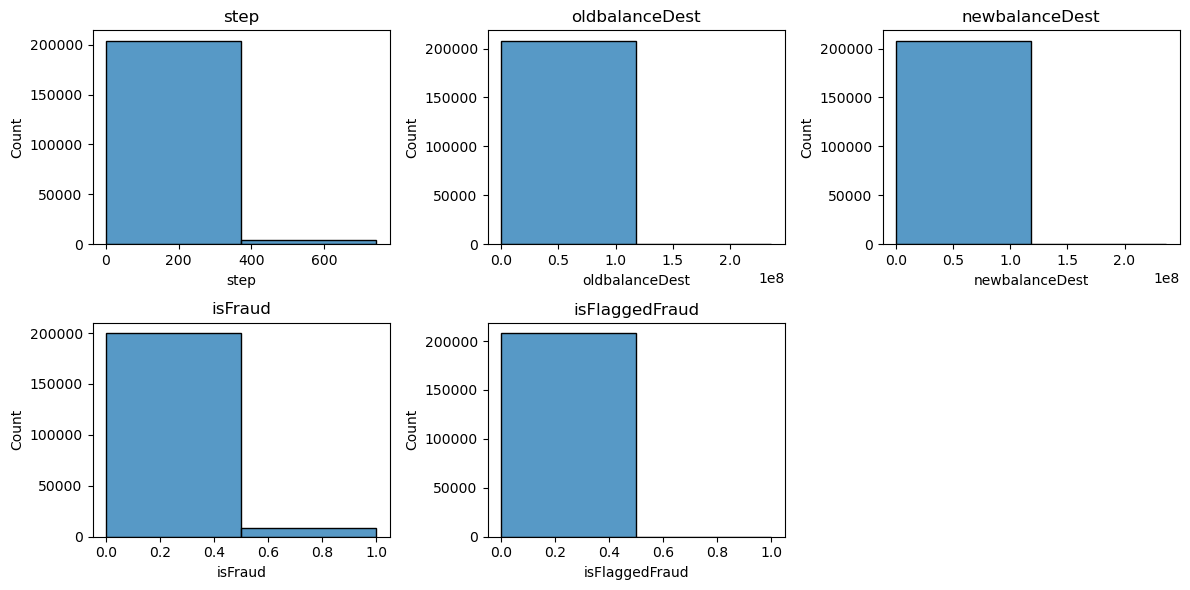

In [15]:
# Create a 2-row, 3-column subplot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # 2 rows, 3 columns

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through the first 6 numeric columns and plot
for i, col in enumerate(numeric_columns[:6]):  # Only the first 6 columns
    sns.histplot(data=df, x=df[col], ax=axes[i],bins=2)
    axes[i].set_title(col)

# Hide any unused subplots if fewer than 6 columns (not needed here but good practice)
for j in range(len(numeric_columns[:6]), len(axes)):
    fig.delaxes(axes[j])  # Delete unused subplot

plt.tight_layout()
plt.show()

In [16]:
df[['step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,208213.00,208213.00,208213.00,208213.00,208213.00
mean,24.21,912345.22,872604.07,925948.79,1195510.94
std,81.95,2804990.99,2778976.28,2419683.44,2715619.94
min,1.00,0.00,0.00,0.00,0.00
25%,9.00,0.00,0.00,0.00,0.00
50%,10.00,20894.00,0.00,40958.30,128019.46
75%,12.00,227866.00,204284.00,738531.50,1186317.31
max,743.00,59585040.00,49585040.00,236230516.82,236726494.66


### Analyze categorical features

In [17]:
df.select_dtypes(exclude=['float64','int64']).columns

Index(['transaction_type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest'],
      dtype='object')

In [18]:
# Unique Identifers:
df[['nameOrig','nameDest']].describe()

,nameOrig,nameDest
count,208213,208213
unique,208208,102590
top,C44568807,C985934102
freq,2,84


In [19]:
categorical_columns = df.select_dtypes(exclude=['float64','int64']).columns[0] 
categorical_columns
# We will only use transaction type column as categorical because the other columns are unique identifiers.

'transaction_type'

## Exploratory Data Analysis

In [20]:
df.head(1)

,step,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181,C1305486145,181,0,C553264065,0.00,0.00,1,0


In [21]:
categorical_columns

'transaction_type'

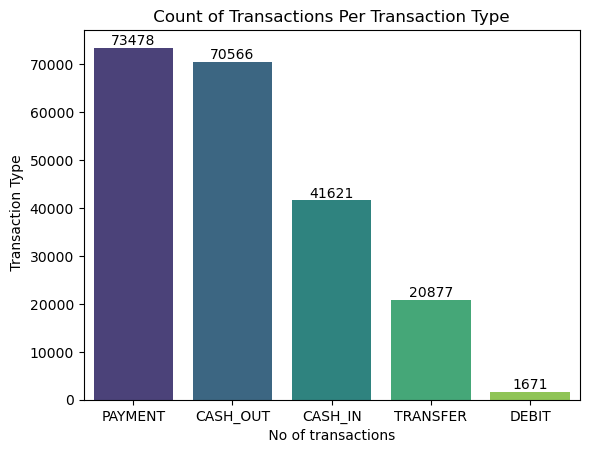

In [22]:
transaction_count = df.groupby('transaction_type')['isFraud'].count().reset_index(name='no of transactions') \
   .sort_values(by='no of transactions',ascending=False)

ax = sns.barplot(data=transaction_count,x='transaction_type',y='no of transactions',palette='viridis')
ax.bar_label(ax.containers[0])

plt.xlabel(" No of transactions ")
plt.title(" Count of Transactions Per Transaction Type ")
plt.ylabel(" Transaction Type")
plt.show()

### Insights

1. Majority of the Transactions were done by Payment method.
2. Very less transactions are directly (DEBIT) made from the account

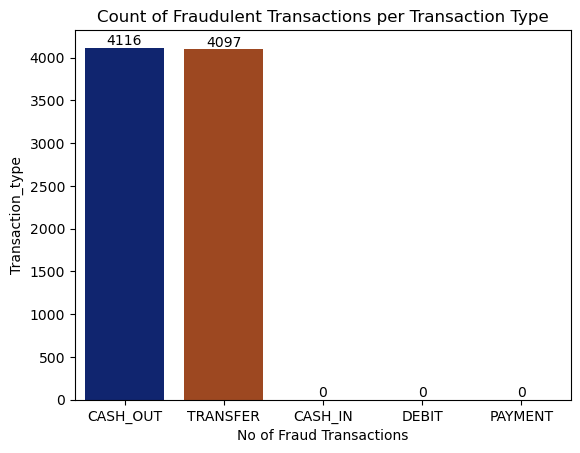

In [23]:
fraud_count_df = df.groupby('transaction_type')['isFraud'].sum().reset_index() \
     .sort_values(by='isFraud',ascending=False) 

ax = sns.barplot(data=fraud_count_df,x='transaction_type',y='isFraud',palette='dark')
ax.bar_label(ax.containers[0])

plt.title("Count of Fraudulent Transactions per Transaction Type")
plt.xlabel("No of Fraud Transactions")
plt.ylabel("Transaction_type")
plt.show()

### Insights

1. Majortiy of the Fraudulent transaction's were either by (CASH OUT) withdrawal of money from the account or by Transfer of funds between two accounts (TRANSFER).

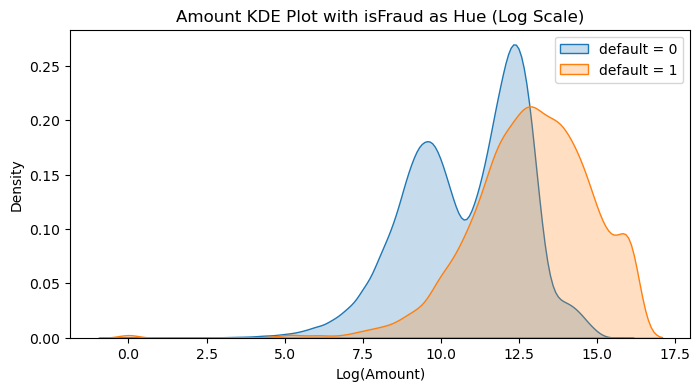

In [24]:
plt.figure(figsize=(8, 4))
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 0]), fill=True, label='default = 0')
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 1]), fill=True, label='default = 1')
plt.title("Amount KDE Plot with isFraud as Hue (Log Scale)")
plt.xlabel("Log(Amount)")
plt.legend()
plt.show()

#### Insights:

1. We can see that Transactions with higher amount have chances of beign FRAUDULENT.
2. Transactions with smaller amount tend to being NON-FRAUDULENT

In [25]:
numeric_columns

Index(['step', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

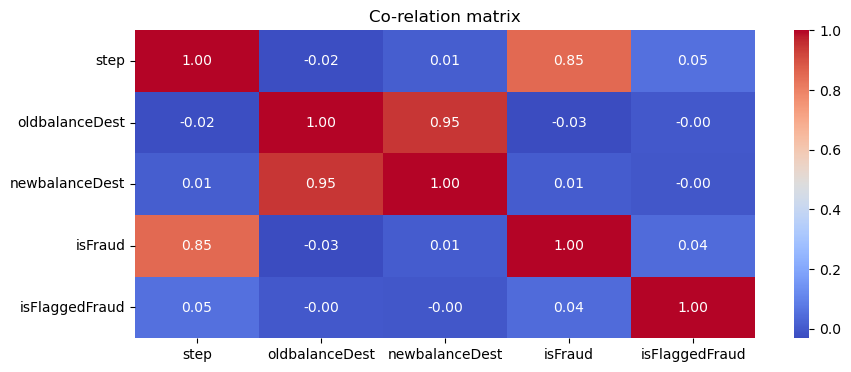

In [26]:
cm = df[numeric_columns].corr()

plt.figure(figsize=(10,4))
sns.heatmap(cm,annot=True,fmt=".2f",cmap='coolwarm')
plt.title("Co-relation matrix")
plt.show()

## Feature Engineering , Feature Selection

In [27]:
df.head(2)

,step,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181,C1305486145,181,0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181,C840083671,181,0,C38997010,21182.00,0.00,1,0


#### Removing columns based on Domain knowledge

In [28]:
df.drop(columns=['step','nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [29]:
df.drop(columns=['oldbalanceDest','newbalanceDest'],inplace=True)
df.head(1)

,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,TRANSFER,181,181,0,1


In [30]:
df['transaction_type'] = df['transaction_type'].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
df.head(3)

,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,4,181,181,0,1
1,1,181,181,0,1
2,4,2806,2806,0,1


### Train Test Split

In [31]:
X = df[['transaction_type','amount','oldbalanceOrg','newbalanceOrig']]
y = df['isFraud']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Model Training

## Attempt 1:


#### Without handling Class Imbalance

In [34]:
# Created a function that takes model, train and test data and returns a classification report.

def get_report(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred) 
    
    print(report)
    

In [35]:
get_report(LogisticRegression(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     60049
           1       0.53      0.98      0.69      2415

    accuracy                           0.97     62464
   macro avg       0.77      0.97      0.84     62464
weighted avg       0.98      0.97      0.97     62464



In [36]:
get_report(DecisionTreeClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       0.96      0.98      0.97      2415

    accuracy                           1.00     62464
   macro avg       0.98      0.99      0.98     62464
weighted avg       1.00      1.00      1.00     62464



In [37]:
get_report(DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_split=30,random_state=42),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       0.95      0.99      0.97      2415

    accuracy                           1.00     62464
   macro avg       0.97      0.99      0.98     62464
weighted avg       1.00      1.00      1.00     62464



In [38]:
get_report(RandomForestClassifier(n_estimators=300, 
    max_depth=10, 
    min_samples_leaf=5, 
    min_samples_split=10, 
    class_weight={0:1, 1:5}, 
    max_features='sqrt',
    bootstrap=True,
    random_state=42),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.89      0.99      0.94      2415

    accuracy                           0.99     62464
   macro avg       0.94      0.99      0.97     62464
weighted avg       1.00      0.99      1.00     62464



## Attempt 2:

#### Handling Class Imbalance using Smote, RandomUnderSampler Techniques:

#### Using SMOTE

In [39]:
from imblearn.over_sampling import SMOTE

In [40]:
smt = SMOTE(random_state=42)

X_resampled,y_resampled = smt.fit_resample(X,y)

In [41]:
get_report(LogisticRegression(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     60049
           1       0.22      0.99      0.35      2415

    accuracy                           0.86     62464
   macro avg       0.61      0.92      0.64     62464
weighted avg       0.97      0.86      0.90     62464



In [42]:
get_report(DecisionTreeClassifier(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       1.00      1.00      1.00      2415

    accuracy                           1.00     62464
   macro avg       1.00      1.00      1.00     62464
weighted avg       1.00      1.00      1.00     62464



In [ ]:
# get_report(RandomForestClassifier(),X_resampled,y_resampled,X_test,y_test)

#### Using RandomUnderSampler:

In [43]:
from imblearn.under_sampling import RandomUnderSampler

In [44]:
under_sampler= RandomUnderSampler(random_state=42)

X_under,y_under = under_sampler.fit_resample(X,y)

In [45]:
get_report(LogisticRegression(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     60049
           1       0.21      0.99      0.35      2415

    accuracy                           0.86     62464
   macro avg       0.61      0.92      0.64     62464
weighted avg       0.97      0.86      0.90     62464



In [46]:
get_report(DecisionTreeClassifier(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.82      1.00      0.90      2415

    accuracy                           0.99     62464
   macro avg       0.91      1.00      0.95     62464
weighted avg       0.99      0.99      0.99     62464



In [ ]:
# get_report(RandomForestClassifier(),X_under,y_under,X_test,y_test)

## Model Fine Tuning

In [47]:
best_model = RandomForestClassifier(n_estimators=300, 
    max_depth=10, 
    min_samples_leaf=5, 
    min_samples_split=10, 
    class_weight={0:1, 1:5}, 
    max_features='sqrt',
    bootstrap=True,
    random_state=42)
best_model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [48]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.89      0.99      0.94      2415

    accuracy                           0.99     62464
   macro avg       0.94      0.99      0.97     62464
weighted avg       1.00      0.99      1.00     62464



### Our Best model is RandomForestClassifier with recall 99% and precision 89%

# Model Evaluation Roc,Auc Curve:

In [49]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
fpr[:5], tpr [:5],thresholds[:5]

(array([0.        , 0.00512914, 1.        ]),
 array([0.        , 0.99461698, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [50]:
auc_score = auc(fpr,tpr)
print(f"Area Under the Curve = {round(auc_score,2)}")

Area Under the Curve = 0.99


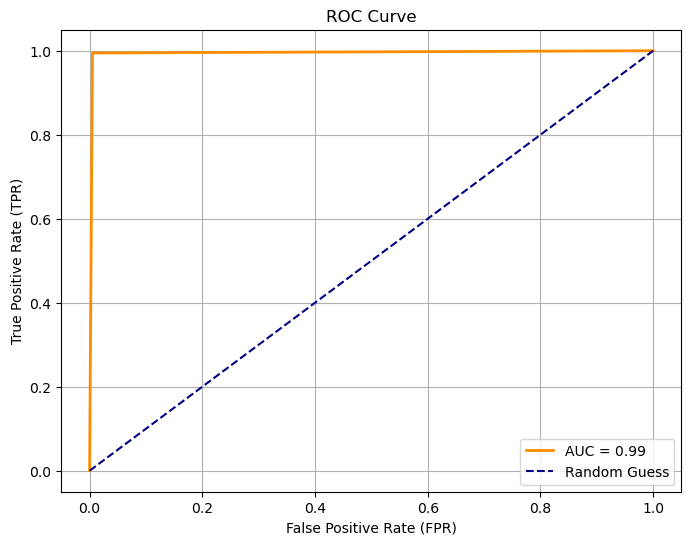

In [51]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [52]:
X.head(2)

,transaction_type,amount,oldbalanceOrg,newbalanceOrig
0,4,181,181,0
1,1,181,181,0


In summary, a RandomForestClassifier aggregates predictions from multiple decision trees, each trained on a different sample of the data. It combines these predictions to improve accuracy and recall on the Fraudulent (1) Class and control overfitting.

In [ ]:
# Dumping the Model and its artifcats.

# from joblib import dump

# model_data = {
#     'model':best_model,
#     'features':X_train.columns,
#     'label_mapping': {0: 'Not Fraud', 1: 'Fraud'} 
# }

# dump(model_data, 'c://Users//adinr//Downloads/fraud_detection_model.pkl')


['c://Users//adinr//Downloads/fraud_detection_model.pkl']

In [55]:
df.query('isFraud == 1 and newbalanceOrig > 0')

,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
28,4,10000000,12930418,2930418,1
104,4,994453,1437370,442917,1
203,1,42062,340830,298767,1
227,4,10000000,11861008,1861008,1
353,4,10000000,19887819,9887819,1
...,...,...,...,...,...
8169,4,10000000,45674547,35674547,1
8171,4,10000000,35674547,25674547,1
8173,4,10000000,25674547,15674547,1
8175,4,10000000,15674547,5674547,1
